In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision.models import resnet50
from torchsummary import summary
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split

import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import math

import albumentations as A
from albumentations.pytorch.transforms import ToTensor

In [2]:
!pip install pkbar
import pkbar

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
main = 'drive/My Drive/FUNDUS DATASET/DIP iCare'
dataset = os.path.join(main, 'MASTER DATASET')
x_dir = os.path.join(dataset, 'FUNDUS IMAGES')
y_dir = os.path.join(dataset, 'GROUND TRUTH')
check_pt_file = os.path.join(main, 'Modified_UNet_e-4_upto100_wdl.pth.tar')
print(len(os.listdir(x_dir)), len(os.listdir(y_dir)))

92 92


#Parameters Setting

In [5]:
num_epochs = 100
batch_size = 4
learning_rate = 1e-4
image_shape = (3, 512, 512)
num_classes = 3
device = "cuda"

#Loading Dataset

In [6]:
transforms = A.Compose(
    [A.HorizontalFlip(p=0.5),
     A.RandomRotate90(p=0.5), #Randomly rotates by 0, 90, 180, 270 degrees
     A.ElasticTransform(p=0.5),
     A.CLAHE(p=1),
     A.RandomBrightnessContrast(p=0.5),
     A.RandomGamma(p=1),
     ToTensor()]
)

In [7]:
class Fundus_Dataset(Dataset):
    def __init__(self, image_dir, mask_dir, transforms=None):
        super(Fundus_Dataset, self).__init__()
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transforms = transforms
        self.class_labels={0: (0,0,0), 1:(255,0,0), 2:(0,0,255)}
                             
    def __len__(self):
        return len(os.listdir(self.image_dir))
    
    def preprocess(self, mask):
        _, result= cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY)
        return result

    def process_mask_to_onehot(self, mask):
        num_classes = len(self.class_labels)
        shape = mask.shape[:2] + (num_classes,)
        onehot = np.zeros(shape)
        for i in range(num_classes):
            onehot[:,:,i] = np.all(mask.reshape((-1, 3)) == self.class_labels[i], axis=1).reshape(shape[:2])
        return onehot

    def process_onehot_to_mask(self, onehot):
        onehot = onehot.permute(0, 2, 3, 1).cpu().detach().numpy()
        single_layer = np.argmax(onehot, axis=-1)
        output = np.zeros(onehot.shape[:3]+(3,))
        for k in self.class_labels.keys():
          output[single_layer==k] = self.class_labels[k]
        output = np.uint8(output)
        return output

    def __getitem__(self, index):
        image_id = sorted(os.listdir(self.image_dir))[index]
        mask_id = sorted(os.listdir(self.mask_dir))[index]

        image_path = os.path.join(self.image_dir, image_id)
        mask_path = os.path.join(self.mask_dir, mask_id)
        image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(mask_path), cv2.COLOR_BGR2RGB)

        mask = self.preprocess(mask)
        onehot = self.process_mask_to_onehot(mask)

        if self.transforms is not None:
          transformed = self.transforms(image=image, mask=onehot)
          image = transformed["image"]
          onehot = transformed["mask"][0].permute(2, 0, 1)
        return image, onehot

In [8]:
dataset = Fundus_Dataset(x_dir, y_dir, transforms=transforms)

generator = torch.Generator().manual_seed(7)

train_dataset, _dataset= random_split(dataset, [72, 20], generator=generator)
val_dataset, test_dataset= random_split(_dataset, [8, 12], generator=generator)

In [9]:
train_loader= DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader= DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader= DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [10]:
print(len(train_loader), len(val_loader), len(test_loader))

18 2 3


#Data

torch.Size([4, 3, 512, 512]) (4, 512, 512, 3) torch.Size([4, 3, 512, 512])


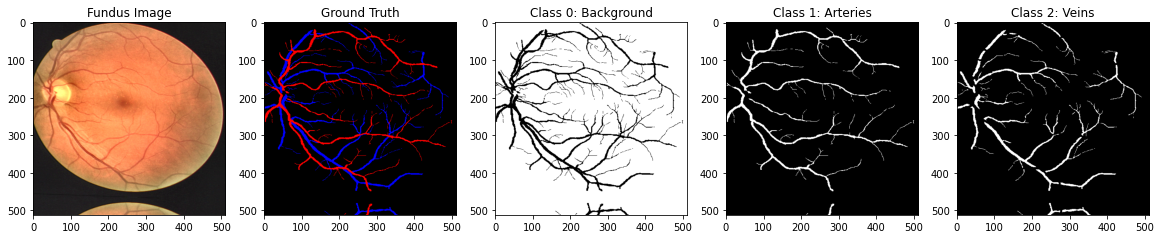

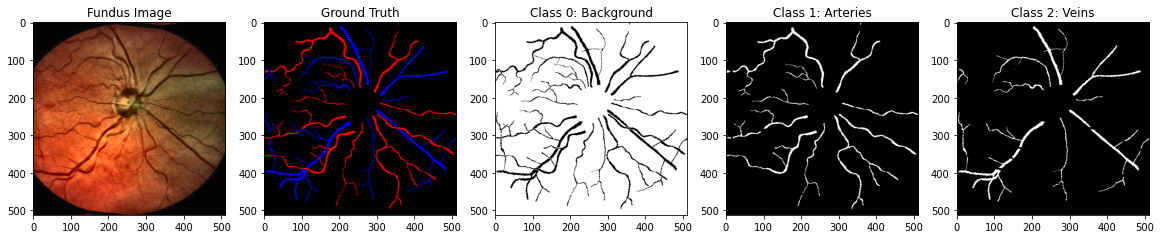

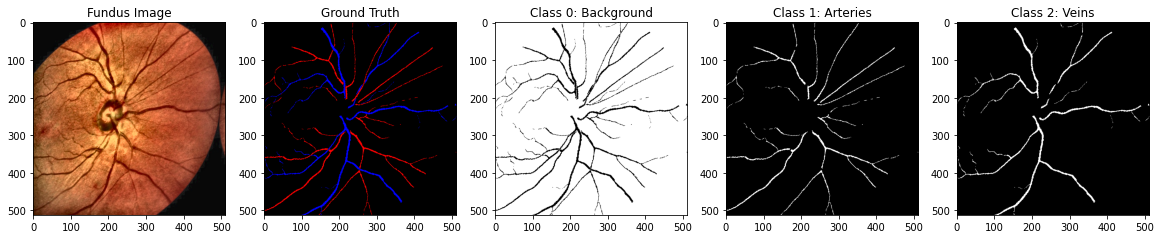

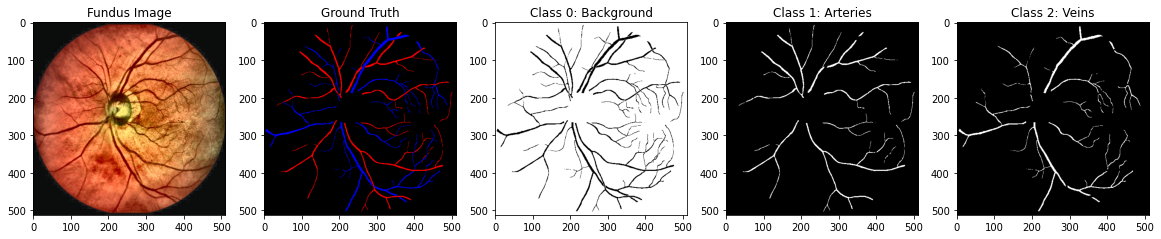

In [11]:
images, onehots= next(iter(test_loader))
masks = dataset.process_onehot_to_mask(onehots)
print(images.shape, masks.shape, onehots.shape)

for i in range(batch_size):
    
    fig = plt.figure(figsize=(20, 8))
    
    ax1 = fig.add_subplot(1,5,1)
    ax1.set_title('Fundus Image')
    ax1.imshow(images[i].permute(1, 2, 0))

    ax2 = fig.add_subplot(1,5,2)
    ax2.set_title('Ground Truth')
    ax2.imshow(masks[i])
    
    ax3 = fig.add_subplot(1,5,3)
    ax3.set_title('Class 0: Background')
    ax3.imshow(onehots[i, 0], 'gray')

    ax4 = fig.add_subplot(1,5,4)
    ax4.set_title('Class 1: Arteries')
    ax4.imshow(onehots[i, 1], 'gray')

    ax5 = fig.add_subplot(1,5,5)
    ax5.set_title('Class 2: Veins')
    ax5.imshow(onehots[i, 2], 'gray')
    
    plt.show()

#Model

In [12]:
class Conv_Block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, bias=True, mode='normal'):
        super(Conv_Block, self).__init__()

        if mode=='normal':
          self.conv = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation, bias=bias),
                                    nn.BatchNorm2d(out_channels),
                                    nn.ReLU(inplace=True))

        elif mode=='separable':
          self.conv = nn.Sequential(nn.Conv2d(in_channels, in_channels, kernel_size, stride=stride, padding=padding, dilation=dilation, groups=in_channels, bias=bias),
                                    nn.BatchNorm2d(in_channels),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias),
                                    nn.BatchNorm2d(out_channels),
                                    nn.ReLU(inplace=True))
      
    def forward(self, x):
        x = self.conv(x)
        return x

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class CBAM_Block(nn.Module):
  def __init__(self, in_features, reduction_ratio = 8):
    super(CBAM_Block, self).__init__()
    self.avgpool = nn.AdaptiveAvgPool2d(1)
    self.maxpool = nn.AdaptiveMaxPool2d(1)
    self.sigmoid = nn.Sigmoid()
    self.MLP = nn.Sequential(nn.Linear(in_features=in_features, out_features=in_features//reduction_ratio, bias=False),
                            nn.ReLU(),
                            nn.Linear(in_features=in_features//reduction_ratio, out_features=in_features, bias=False))
    self.conv_s = nn.Conv2d(in_channels=2, out_channels=1, kernel_size=7, stride=1, padding=3, bias=False)
    
  def get_channel_attention(self, x):
    Fc_avg = torch.squeeze(self.avgpool(x))
    Fc_max = torch.squeeze(self.maxpool(x))
    Fc = self.sigmoid(self.MLP(Fc_avg)+self.MLP(Fc_max))
    return torch.unsqueeze(torch.unsqueeze(Fc, 2), 3)

  def get_spatial_attention(self, x):
    Fs_avg = torch.mean(x, dim=1, keepdim=True)
    Fs_max, _ = torch.max(x, dim=1, keepdim=True)
    return self.sigmoid(self.conv_s(torch.cat((Fs_avg, Fs_max), dim=1)))
  
  def forward(self, x):
    x = self.get_channel_attention(x)*x
    x = self.get_spatial_attention(x)*x
    return x

class Modified_UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=3, features=[64, 128, 256, 512],
    ):
        super(Modified_UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2,))
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = nn.Sequential(nn.Conv2d(features[-1], features[-1]*2, 3, 1, 1, bias=False),
                                        nn.BatchNorm2d(features[-1]*2),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(p=0.2),
                                        CBAM_Block(features[-1]*2),
                                        nn.Conv2d(features[-1]*2, features[-1]*2, 3, 1, 1, bias=False),
                                        nn.BatchNorm2d(features[-1]*2),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(p=0.2))
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        # self.sgmd = nn.Sigmoid()
        self.sftmx = nn.Softmax(dim=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)
        x = self.final_conv(x)
        x = self.sftmx(x)
        return x

In [13]:
# class Recurrent_block(nn.Module):
#     def __init__(self, in_ch, out_ch, t=2):
#         super(Recurrent_block, self).__init__()
#         self.t = t
#         self.conv = nn.Sequential(
#             nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
#             nn.BatchNorm2d(out_ch),
#             nn.ReLU(inplace=True))
        
#     def forward(self, x):
#         for i in range(self.t):
#             if i == 0:
#                 x2 = self.conv(x)
#             x2 = self.conv(x + x2)
#         return x2
#         # x2 = conv(x + conv(x)) after i==0
#         # x2 = conv(x + conv(x + conv(x))) after i==1

# class DoubleRRConv(nn.Module):
#     def __init__(self, in_ch, out_ch, t=2):
#         super(DoubleRRConv, self).__init__()
#         self.RCNN = nn.Sequential(
#             Recurrent_block(out_ch, out_ch, t=t),
#             Recurrent_block(out_ch, out_ch, t=t))
#         self.Conv = nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=1, padding=0)

#     def forward(self, x):
#         x = self.Conv(x)
#         x2 = self.RCNN(x)
#         out = x + x2
#         return out

# class R2UNET(nn.Module):
#     def __init__(
#             self, in_channels=3, out_channels=3, features=[64, 128, 256, 512],
#     ):
#         super(R2UNET, self).__init__()
#         self.ups = nn.ModuleList()
#         self.downs = nn.ModuleList()
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

#         # Down part of UNET
#         for feature in features:
#             self.downs.append(DoubleRRConv(in_channels, feature))
#             in_channels = feature

#         # Up part of UNET
#         for feature in reversed(features):
#             self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2,))
#             self.ups.append(DoubleRRConv(feature*2, feature))

#         self.bottleneck = DoubleRRConv(features[-1], features[-1]*2)
#         self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
#         self.sftmx = nn.Softmax(dim=1)

#     def forward(self, x):
#         skip_connections = []

#         for down in self.downs:
#             x = down(x)
#             skip_connections.append(x)
#             x = self.pool(x)

#         x = self.bottleneck(x)
#         skip_connections = skip_connections[::-1]

#         for idx in range(0, len(self.ups), 2):
#             x = self.ups[idx](x)
#             skip_connection = skip_connections[idx//2]

#             if x.shape != skip_connection.shape:
#                 x = TF.resize(x, size=skip_connection.shape[2:])

#             concat_skip = torch.cat((skip_connection, x), dim=1)
#             x = self.ups[idx+1](concat_skip)

#         x = self.final_conv(x)
#         x = self.sftmx(x)
#         return x

In [14]:
# class DoubleConv(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(DoubleConv, self).__init__()
#         self.conv = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#         )

#     def forward(self, x):
#         return self.conv(x)

# class UNET(nn.Module):
#     def __init__(
#             self, in_channels=3, out_channels=3, features=[64, 128, 256, 512],
#     ):
#         super(UNET, self).__init__()
#         self.ups = nn.ModuleList()
#         self.downs = nn.ModuleList()
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

#         # Down part of UNET
#         for feature in features:
#             self.downs.append(DoubleConv(in_channels, feature))
#             in_channels = feature

#         # Up part of UNET
#         for feature in reversed(features):
#             self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2,))
#             self.ups.append(DoubleConv(feature*2, feature))

#         self.bottleneck = nn.Sequential(nn.Conv2d(features[-1], features[-1]*2, 3, 1, 1, bias=False),
#                                         nn.BatchNorm2d(features[-1]*2),
#                                         nn.ReLU(inplace=True),
#                                         nn.Dropout(p=0.2),
#                                         nn.Conv2d(features[-1]*2, features[-1]*2, 3, 1, 1, bias=False),
#                                         nn.BatchNorm2d(features[-1]*2),
#                                         nn.ReLU(inplace=True),
#                                         nn.Dropout(p=0.2))
#         self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
#         # self.sgmd = nn.Sigmoid()
#         self.sftmx = nn.Softmax(dim=1)

#     def forward(self, x):
#         skip_connections = []

#         for down in self.downs:
#             x = down(x)
#             skip_connections.append(x)
#             x = self.pool(x)

#         x = self.bottleneck(x)
#         skip_connections = skip_connections[::-1]

#         for idx in range(0, len(self.ups), 2):
#             x = self.ups[idx](x)
#             skip_connection = skip_connections[idx//2]

#             if x.shape != skip_connection.shape:
#                 x = TF.resize(x, size=skip_connection.shape[2:])

#             concat_skip = torch.cat((skip_connection, x), dim=1)
#             x = self.ups[idx+1](concat_skip)
#         x = self.final_conv(x)
#         x = self.sftmx(x)
#         return x

In [15]:
model = Modified_UNET().to(device=device)
summary(model, input_size=(3, 512, 512), batch_size=batch_size, device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [4, 64, 512, 512]           1,728
       BatchNorm2d-2          [4, 64, 512, 512]             128
              ReLU-3          [4, 64, 512, 512]               0
            Conv2d-4          [4, 64, 512, 512]          36,864
       BatchNorm2d-5          [4, 64, 512, 512]             128
              ReLU-6          [4, 64, 512, 512]               0
        DoubleConv-7          [4, 64, 512, 512]               0
         MaxPool2d-8          [4, 64, 256, 256]               0
            Conv2d-9         [4, 128, 256, 256]          73,728
      BatchNorm2d-10         [4, 128, 256, 256]             256
             ReLU-11         [4, 128, 256, 256]               0
           Conv2d-12         [4, 128, 256, 256]         147,456
      BatchNorm2d-13         [4, 128, 256, 256]             256
             ReLU-14         [4, 128, 2

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


# Training

In [16]:
# weights = torch.Tensor([0.07246022, 0.9662471, 0.96129268]) #Black, Red, Blue
weights = torch.Tensor([0.00075166, 0.56762921, 0.43161913]) #for wdl
weights = weights.to(device)

In [17]:
class DICE_LOSS(nn.Module):
    def __init__(self, class_weights, weight=None, size_average=True):
        super(DICE_LOSS, self).__init__()
        # self.sigmoid = nn.Sigmoid()
        self.class_weights = class_weights
        
    def forward(self, inputs, targets, smooth=1):        
        # inputs = self.sigmoid(inputs)
        inputs = torch.flatten(inputs, start_dim=0, end_dim=2)
        targets = torch.flatten(targets, start_dim=0, end_dim=2)
        
        intersection = (inputs * targets * self.class_weights).sum()  
        union = ((inputs + targets)*self.class_weights).sum()
        
        dice = (2.*intersection + smooth)/(union + smooth)
        return 1-dice

In [18]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
Loss = DICE_LOSS(class_weights=weights)
# Loss = nn.CrossEntropyLoss(weight = weights)

In [19]:
# def check_accuracy(scores, targets):
#   num_correct=0
#   num_samples=0
#   dice_score=0
#   # predictions = torch.sigmoid(scores)
#   predictions = (scores>0.5).float()
#   num_correct += (predictions == targets).sum()
#   num_samples += torch.numel(predictions)
#   dice_score += (2*(predictions*targets).sum())/((predictions+targets).sum() + 1e-8) 
#   return dice_score

def dice_coef(scores, targets):
  smooth = 1
  # scores = torch.sigmoid(scores)
  scores = torch.flatten(scores, start_dim=0, end_dim=2)
  targets = torch.flatten(targets, start_dim=0, end_dim=2)
  intersection = (scores*targets).sum()
  union = (scores+targets).sum()
  dice = (2*intersection + smooth)/(union+smooth)
  return dice

def save_checkpoint(model, optimizer, file_name):
  checkpoint= {'state_dict': model.state_dict(),
             'optimizer_dict': optimizer.state_dict()}
  torch.save(checkpoint, file_name)

def load_checkpoint(model, optimizer, file_name):
  check_pt = torch.load(file_name, map_location= torch.device(device))
  model.load_state_dict(check_pt['state_dict'])
  optimizer.load_state_dict(check_pt['optimizer_dict'])
  return model, optimizer

In [20]:
train_per_epoch = len(train_loader)
val_per_epoch = len(val_loader)
min_loss = math.inf

for epoch in range(num_epochs):
  train_losses = []
  train_dcs = []
  kbar_train = pkbar.Kbar(target = train_per_epoch, epoch = epoch, num_epochs = num_epochs)
  model.train()
  for batch_idx, (data, targets) in enumerate(train_loader):
    data = data.to(device=device)
    targets = targets.to(device=device)
    # targets = targets.to(torch.long)
    # proper_targets = torch.argmax(targets, dim=1)

    scores = model(data)
    train_loss = Loss(scores.permute(0,2,3,1), targets.permute(0,2,3,1))
    train_losses.append(train_loss.item())
    
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    train_dc = dice_coef(scores.permute(0,2,3,1), targets.permute(0,2,3,1))
    train_dcs.append(train_dc.item())
    kbar_train.update(batch_idx+1, values=[("loss", train_loss.item()), ("dice_score", train_dc.item())])
  
  mean_train_loss = sum(train_losses)/len(train_losses)
  mean_train_dc = sum(train_dcs)/len(train_dcs)
  print()
  # scheduler.step(mean_train_loss)
  # kbar_train.update(train_per_epoch, values=[("loss", mean_train_loss), ("dice_score", mean_train_dc)])#For each epoch
  
  val_losses = []
  val_dcs = []
  kbar_val = pkbar.Kbar(target = val_per_epoch, epoch = epoch, num_epochs = num_epochs)
  with torch.no_grad():
    model.eval()
    for batch_idx, (data, targets) in enumerate(val_loader):
      data = data.to(device=device)
      targets = targets.to(device=device)
      # targets = targets.to(torch.long)
      # proper_targets = torch.argmax(targets, dim=1)
    
      scores = model(data)
      val_loss = Loss(scores.permute(0,2,3,1), targets.permute(0,2,3,1))
      val_losses.append(val_loss.item())

      val_dc = dice_coef(scores.permute(0,2,3,1), targets.permute(0,2,3,1))
      val_dcs.append(val_dc.item())
      kbar_val.update(batch_idx+1, values=[("val_loss", val_loss.item()), ("val_dice_score", val_dc.item())])
    
    mean_val_loss = sum(val_losses)/len(val_losses)
    mean_val_dc = sum(val_dcs)/len(val_dcs)
    # kbar_val.update(val_per_epoch, values=[("val_loss", mean_val_loss), ("val_dice_score", mean_val_dc)])#For each epoch
    
    if mean_val_loss < min_loss:
      min_loss = mean_val_loss
      print('\nImproved validation loss: {:.4f}'.format(min_loss))
      save_checkpoint(model, optimizer, check_pt_file)
      print('Model saved to {}\n'.format(check_pt_file))

Epoch: 1/100
18/18 [==============================] - 39s 2s/step - loss: 0.9060 - dice_score: 0.4158

Epoch: 1/100
2/2 [==============================] - 4s 2s/step - val_loss: 0.9400 - val_dice_score: 0.3003

Improved validation loss: 0.9400
Model saved to drive/My Drive/FUNDUS DATASET/DIP iCare/Modified_UNet_e-4_upto100_wdl.pth.tar

Epoch: 2/100
18/18 [==============================] - 45s 2s/step - loss: 0.8699 - dice_score: 0.5046

Epoch: 2/100
2/2 [==============================] - 5s 2s/step - val_loss: 0.9148 - val_dice_score: 0.4173

Improved validation loss: 0.9148
Model saved to drive/My Drive/FUNDUS DATASET/DIP iCare/Modified_UNet_e-4_upto100_wdl.pth.tar

Epoch: 3/100
18/18 [==============================] - 47s 3s/step - loss: 0.8413 - dice_score: 0.5741

Epoch: 3/100
2/2 [==============================] - 5s 2s/step - val_loss: 0.8616 - val_dice_score: 0.5436

Improved validation loss: 0.8616
Model saved to drive/My Drive/FUNDUS DATASET/DIP iCare/Modified_UNet_e-4_upto100

#Testing

In [21]:
unet, _ = load_checkpoint(model, optimizer, check_pt_file)

x, y = next(iter(test_loader))
x = x.to(device=device)
y = y.to(device=device)
unet.eval()
yhat = unet(x)

In [22]:
print(x.shape, y.shape, yhat.shape)

torch.Size([4, 3, 512, 512]) torch.Size([4, 3, 512, 512]) torch.Size([4, 3, 512, 512])


In [23]:
# t = torch.Tensor([0.5]).to(device)
# yhat1 = (yhat > t).float()
# print(yhat1.shape)

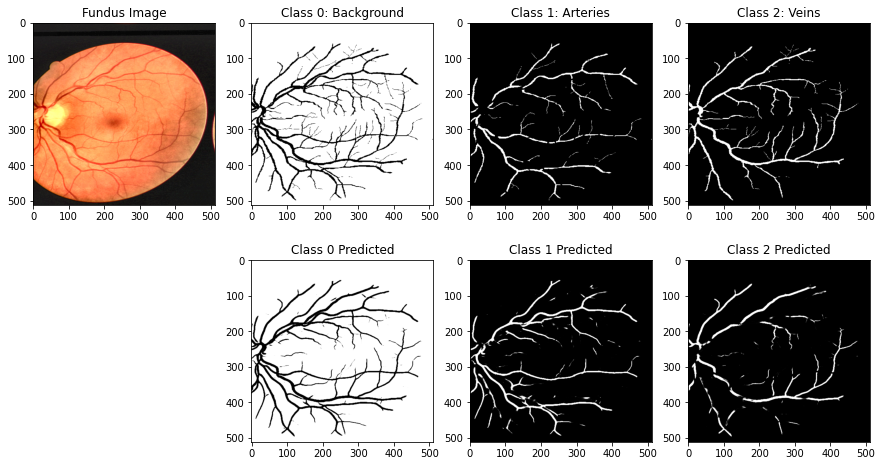

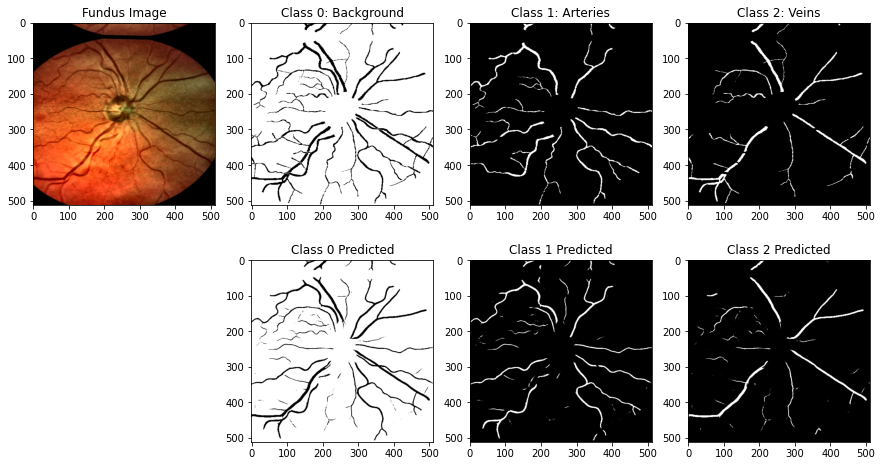

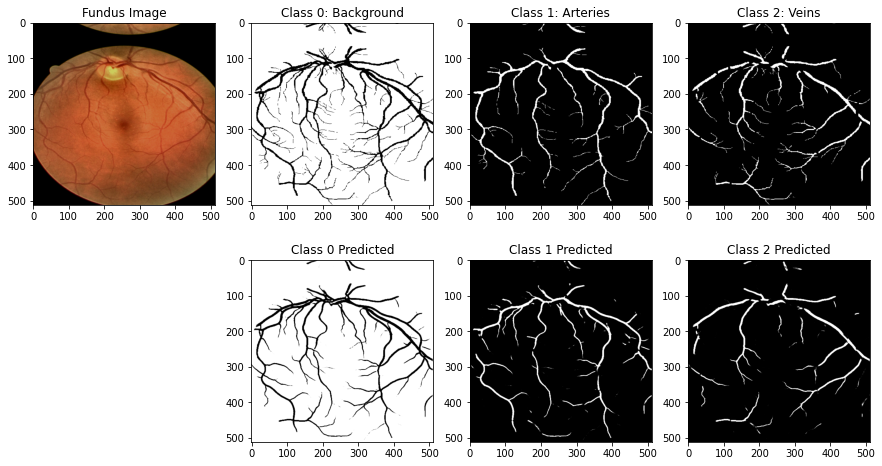

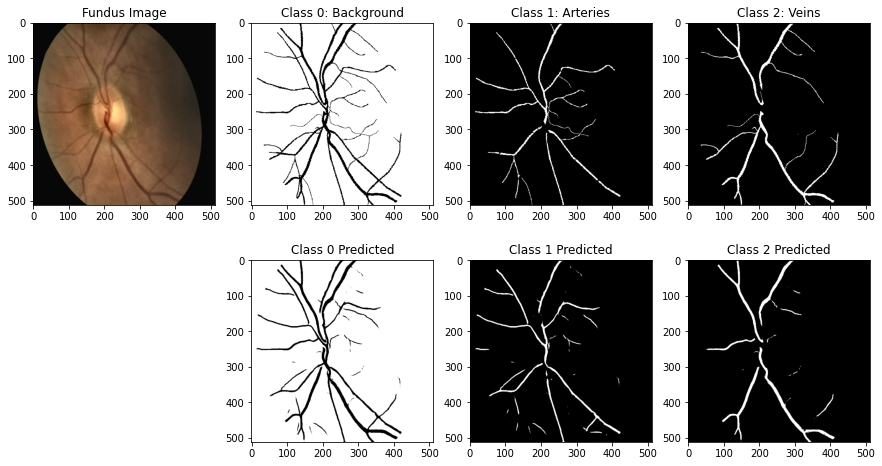

In [24]:
for i in range(batch_size):
    fig = plt.figure(figsize=(15,8))
    
    ax1 = fig.add_subplot(2,4,1)
    ax1.set_title('Fundus Image')
    ax1.imshow(x[i].permute(1, 2, 0).cpu().numpy())

    ax2 = fig.add_subplot(2,4,2)
    ax2.set_title('Class 0: Background')
    ax2.imshow(y[i, 0].cpu(), 'gray')

    ax3 = fig.add_subplot(2,4,3)
    ax3.set_title('Class 1: Arteries')
    ax3.imshow(y[i, 1].cpu(), 'gray')

    ax4 = fig.add_subplot(2,4,4)
    ax4.set_title('Class 2: Veins')
    ax4.imshow(y[i, 2].cpu(), 'gray')
    
    ax5 = fig.add_subplot(2,4,6)
    ax5.set_title('Class 0 Predicted')
    ax5.imshow(yhat[i, 0].cpu().detach().numpy(), 'gray')

    ax6 = fig.add_subplot(2,4,7)
    ax6.set_title('Class 1 Predicted')
    ax6.imshow(yhat[i, 1].cpu().detach().numpy(), 'gray')

    ax7 = fig.add_subplot(2,4,8)
    ax7.set_title('Class 2 Predicted')
    ax7.imshow(yhat[i, 2].cpu().detach().numpy(), 'gray')
    
    plt.show()

In [25]:
y_mask= dataset.process_onehot_to_mask(y)
pred_mask= dataset.process_onehot_to_mask(yhat)
print(y_mask.shape, pred_mask.shape)

(4, 512, 512, 3) (4, 512, 512, 3)


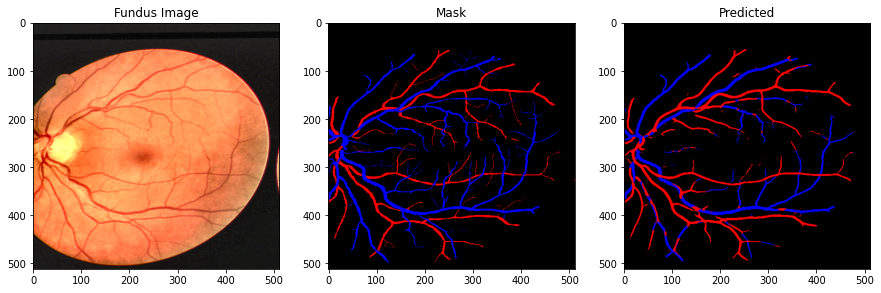

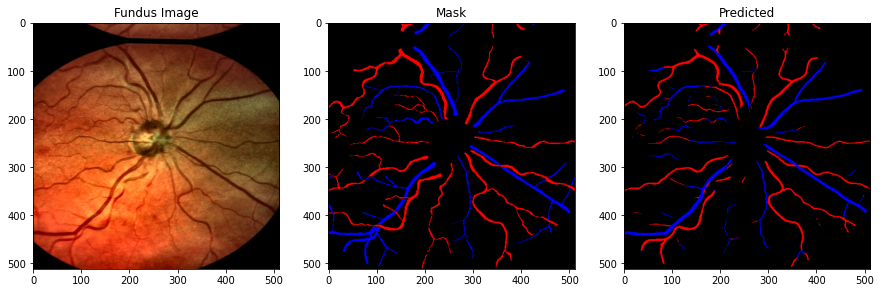

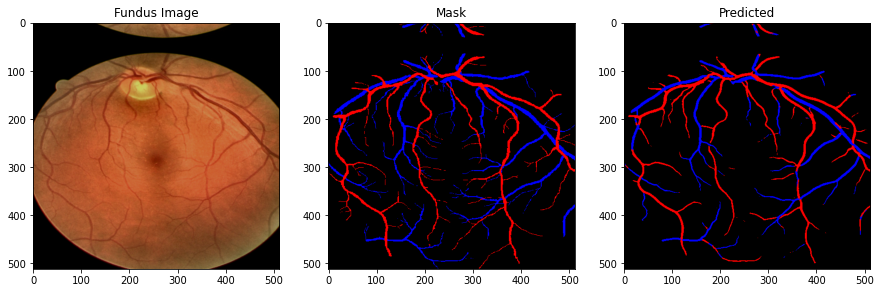

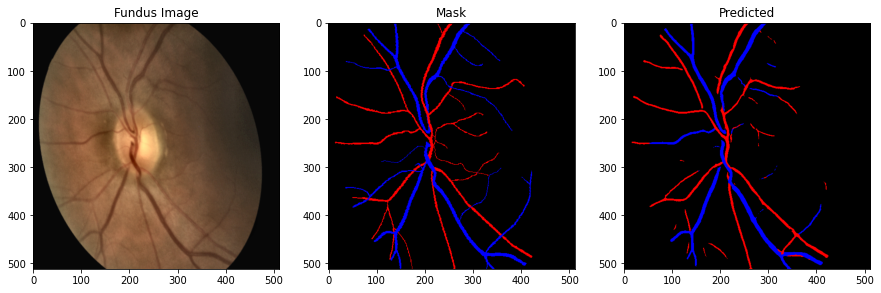

In [26]:
for i in range(batch_size):
    fig = plt.figure(figsize=(15,8))
    
    ax1 = fig.add_subplot(1,3,1)
    ax1.set_title('Fundus Image')
    ax1.imshow(x[i].permute(1, 2, 0).cpu().numpy())

    ax2 = fig.add_subplot(1,3,2)
    ax2.set_title('Mask')
    ax2.imshow(y_mask[i])

    ax3 = fig.add_subplot(1,3,3)
    ax3.set_title('Predicted')
    ax3.imshow(pred_mask[i])
    
    plt.show()